# 4. Exploratory Analysis

**Purpose:** It should be possible to parse the SMILES structural codes into meaningful chemical information (molecular weight, hydrogen bond donors/acceptors, degree of branching, etc.) that is useful in predicting the compound's boiling point. This notebook evaluates that hypothesis by parsing a subset of the structural codes and examining the correlation of potential features with boiling point.

**Contents:** The notebook contains:
* A function to parse input plain-text SMILES structures into potentially relevant features using the [RDKit library](https://www.rdkit.org/docs/Overview.html).
* Determination of Spearman correlation coefficients between potential features and boiling point data.
* Visualization of feature distribution.
* Upsampling of the data reflecting boiling points of aromatic molecules, which are under-represented in the original data set.

**Conclusions:** Key conclusions & outputs are:
* The following features are selected for subsequent model development:
    * The molecule's *molecular weight*.
    * The *branching fraction*, which is defined here as the fraction of aliphatic carbon atoms that are branch points in an otherwise linear structure.
    * The *number of hydrogen bond donors* (such as alcohols and primary/secondary amines) that are present.
* The dataset includes *very few* molecules with >1 hydrogen bond donor. Any subsequent model will not provide accurate predictions for molecules of this class.
* Upsampled training sets are exported to the `data` folder.

*Note:* For copyright reasons, the database and exported CSV files are not included in this repository.

## Import the necessary modules & data.

In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Lipinski, Descriptors
from numpy import nan

In [2]:
# Import the training sets.
x_train = pd.read_csv("data/x_train-CHNO.csv")
y_train = pd.read_csv("data/y_train-CHNO.csv")

## Create a combined data set.

In [3]:
# Merge the training sets into a combined data frame.
xy_train = x_train.copy()
xy_train["BP"] = y_train

In [4]:
x_train

,SMILES
0,CCCCCCCCCC(C)CCCCCC=C
1,CCCC(C)c1ccccc1
2,CCc1cc(C)ccc1C
3,CCCCCCCCCCC(=O)CCCCCC
4,CCCCCCCCCC(C)OCC
...,...
6136,CCCCCCCC=CCCC(C)O
6137,CC(CCCCCC=C)C(C)C=O
6138,CCCCCCCCCC(C)(C)CCO
6139,CCC(C)CCC(CC)C(C)C


## Define a function for parsing SMILES codes.

First, use dictionaries to define functional groups and other structural features of interest. Then, use a function to append this interpreted structural information to `xy_train` as a series of new columns.

First, let's define a function to pull *a lot* of potential boiling point predictors out of the SMILES structural code. The `RDKit` module will do a lot of the heavy lifting here, and we'll only use a small portion of these in actually training the model later.

I selected these potential features based on knowledge of the underlying chemistry. I included potential features that I thought would correlate strongly to boiling point (e.g.: molecular weight, hydrogen bond donors), in addition to others that I expected to have a weaker correlation, if any at all.

In [5]:
# This dict contains functional groups defined by SMARTS substructure codes.
# The interpret_smiles() function will use these definitions to count the number
# of times each functional group occurs within a SMILES code.

descriptors1 = {
                "alcohols, any type" : Chem.MolFromSmarts("[#6;!$(C=O)][OX2H1]"),
                "alcohol, primary" : Chem.MolFromSmarts("[CH2]([#6])[OH1]"),
                "alcohol, secondary" : Chem.MolFromSmarts("[CH1]([#6])([#6])[OH1]"),
                "alcohol, tertiary" : Chem.MolFromSmarts("[CH0]([#6])([#6])([#6])[OH1]"),
                "alcohol, vinyl" : Chem.MolFromSmarts("[$([CX3]=[CX3])][OH1]"),
                "alcohol, aryl" : Chem.MolFromSmarts("a[OH1]"),
                "ethers" : Chem.MolFromSmarts("[OD2]([#6;!$(C=O)])[#6;!$(C=O)]"),
                "amines, primary" : Chem.MolFromSmarts("[#6][NX3;H2;!$(NC=O)]"),
                "amines, secondary" : Chem.MolFromSmarts("[#6][NX3;H1;!$(NC=O)]"),
                "amines, tertiary" : Chem.MolFromSmarts("[#6][NX3;H0;!$(NC=O)]"),
                "carbonyl, all types" : Chem.MolFromSmarts("[CX3]=[OX1]"),
                "carbonyl, ester" : Chem.MolFromSmarts("[#6][CX3](=[OX1])O[C,c]"),
                "carbonyl, acid " : Chem.MolFromSmarts("[#6][CX3](=[OX1])[OH]"),
                "carbonyl, all amides" : Chem.MolFromSmarts("[#6][CX3](=[OX1])[NX3]"),
                "carbonyl, primary amides" : Chem.MolFromSmarts("[#6][CX3](=[OX1])[NX3H2]"),
                "carbonyl, secondary amides" : Chem.MolFromSmarts("[#6][CX3](=[OX1])[NX3H1]"),
                "carbonyl, tertiary amides" : Chem.MolFromSmarts("[#6][CX3](=[OX1])[NX3H0]"),
                "carbonyl, aldehyde" : Chem.MolFromSmarts("[#6][CH1X3](=[OX1])"),
                "carbonyl, ketone" : Chem.MolFromSmarts("[#6][CX3](=[OX1])[#6]"),
                "imine" : Chem.MolFromSmarts("[$([CX3]([#6])[#6]),$([CX3H][#6])]=[$([NX2][#6]),$([NX2H])]"),
                "nitrile" : Chem.MolFromSmarts("[NX1]#[CX2]"),
                "olefins, all types" : Chem.MolFromSmarts("[CX3]=[CX3]"),
                "alkynes, all types" : Chem.MolFromSmarts("[CX2]#[CX2]"),
                "carbon atoms, all" : Chem.MolFromSmarts("[#6]"),
                "carbon atoms, all aliphatic" : Chem.MolFromSmarts("[CX4]"),
                "carbon atoms, aliphatic branches" : Chem.MolFromSmarts("[$([C;H1,H0]([#6])([#6])([#6]))]"),
                "halides, total" : Chem.MolFromSmarts("[F,Cl,Br,I]"),
                "halides, bromide" : Chem.MolFromSmarts("[Br]"),
                "halides, iodide" : Chem.MolFromSmarts("[I]"),
                }

In [6]:
# This dict contains other structural information that may be useful in
# estimating boiling points. These descriptors do _not_ use SMARTS substructures.
# The interpret_smiles() function will use these definitions to generate
# additional substructure information from a SMILES code.

descriptors2 = {
                "rings, aromatic" : Lipinski.NumAromaticRings,
                "rings, saturated" : Lipinski.NumAliphaticRings,
                "H-bond acceptors" : Lipinski.NumHAcceptors,
                "H-Bond donors" : Lipinski.NumHDonors,
                "heavy atom count" : Lipinski.HeavyAtomCount,
                "molecular weight" : Descriptors.ExactMolWt
                }

In [7]:
# This function will accept a single row from the bp_data dataframe.

def interpret_smiles(row):
    
    # Get the SMILES code, then use it to create an RDKit mol object.
    smiles_code = row["SMILES"]
    molecule = Chem.MolFromSmiles(smiles_code)
    
    # If the SMILES code was properly interpreted, compute the descriptors of interest.
    # If not, populate the columns with NaN instead.
    
    if molecule is not None:

        # Add new columns with counts of each of the functional groups defined in
        # the descriptors1 dict.
        for property in descriptors1.keys():
            row[property] = len(molecule.GetSubstructMatches(descriptors1[property]))

        # Add new columns with counts of each of the properties defined in
        # the descriptors2 dict.
        for property in descriptors2.keys():
            row[property] = descriptors2[property](molecule)
            
    else:
        for property in descriptors1.keys():
            row[property] = nan
        for property in descriptors2.keys():
            row[property] = nan
        
    return row

## Parse the SMILES codes.
Actually use the `interpret_smiles()` function defined above.

In [8]:
xy_train = xy_train.apply(interpret_smiles, axis = 1)

How many SMILES codes couldn't be interpreted?

In [9]:
xy_train[xy_train.isna().any(axis = 1)]

,SMILES,BP,"alcohols, any type","alcohol, primary","alcohol, secondary","alcohol, tertiary","alcohol, vinyl","alcohol, aryl",ethers,"amines, primary",...,"carbon atoms, aliphatic branches","halides, total","halides, bromide","halides, iodide","rings, aromatic","rings, saturated",H-bond acceptors,H-Bond donors,heavy atom count,molecular weight


Nice! Only one SMILES code failed here.

Let's add a couple secondary parameters, calculated from some of the results returned by `RDKit`: the fraction of carbon atoms that are aliphatic, and the degree of branching (a ratio of branched carbons to total carbon atoms).

In [10]:
xy_train["aliphatic fraction"] = xy_train["carbon atoms, all aliphatic"] / xy_train["carbon atoms, all"]

In [11]:
def calc_branch_frac(row):
    if row["carbon atoms, all aliphatic"] != 0:
        row["branching fraction"] = row["carbon atoms, aliphatic branches"] / row["carbon atoms, all"]
    else:
        row["branching fraction"] = nan
        
    return row

In [12]:
xy_train = xy_train.apply(calc_branch_frac, axis = 1)

In [13]:
xy_train.head()

,SMILES,BP,"alcohols, any type","alcohol, primary","alcohol, secondary","alcohol, tertiary","alcohol, vinyl","alcohol, aryl",ethers,"amines, primary",...,"halides, bromide","halides, iodide","rings, aromatic","rings, saturated",H-bond acceptors,H-Bond donors,heavy atom count,molecular weight,aliphatic fraction,branching fraction
0,CCCCCCCCCC(C)CCCCCC=C,578.81,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,18,252.281701,0.888889,0.055556
1,CCCC(C)c1ccccc1,473.15,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,11,148.125201,0.454545,0.090909
2,CCc1cc(C)ccc1C,459.98,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,10,134.109550,0.400000,0.000000
3,CCCCCCCCCCC(=O)CCCCCC,595.82,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,18,254.260966,0.941176,0.000000
4,CCCCCCCCCC(C)OCC,511.26,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,14,200.214016,1.000000,0.000000


## Examine correlation coefficients.
Determine the Spearman correlation coefficients to evaluate which of these structural components might be good features to use when we're ready to train the model.

In [14]:
pd.options.display.max_rows, pd.options.display.max_columns = None, None
xy_train.corr(method = "spearman")

,BP,"alcohols, any type","alcohol, primary","alcohol, secondary","alcohol, tertiary","alcohol, vinyl","alcohol, aryl",ethers,"amines, primary","amines, secondary","amines, tertiary","carbonyl, all types","carbonyl, ester","carbonyl, acid","carbonyl, all amides","carbonyl, primary amides","carbonyl, secondary amides","carbonyl, tertiary amides","carbonyl, aldehyde","carbonyl, ketone",imine,nitrile,"olefins, all types","alkynes, all types","carbon atoms, all","carbon atoms, all aliphatic","carbon atoms, aliphatic branches","halides, total","halides, bromide","halides, iodide","rings, aromatic","rings, saturated",H-bond acceptors,H-Bond donors,heavy atom count,molecular weight,aliphatic fraction,branching fraction
BP,1.000000,-0.043461,0.020605,-0.022495,-0.115086,NaN,-0.047698,-0.116684,0.014506,0.000980,-0.048064,0.287804,-0.149488,0.494253,-0.006624,NaN,NaN,-0.006624,0.059583,0.065431,-0.011152,0.032403,0.217522,0.058327,0.830177,0.610937,-0.192867,NaN,NaN,NaN,-0.042096,-0.074927,0.100297,0.347289,0.884269,0.857830,-0.108733,-0.423857
"alcohols, any type",-0.043461,1.000000,0.775988,0.418876,0.268087,NaN,0.278882,-0.056383,-0.033573,-0.036399,-0.039344,-0.364939,-0.145643,-0.154576,-0.006975,NaN,NaN,-0.006975,-0.152026,-0.088583,-0.004932,-0.019123,0.081287,-0.129528,-0.203014,-0.125175,-0.056547,NaN,NaN,NaN,-0.010011,-0.039688,0.135589,0.610683,-0.195603,-0.166369,0.091285,0.021685
"alcohol, primary",0.020605,0.775988,1.000000,-0.048590,-0.025245,NaN,-0.032212,-0.043767,-0.026061,-0.028255,-0.030541,-0.285143,-0.114327,-0.119990,-0.005415,NaN,NaN,-0.005415,-0.118011,-0.070450,-0.003828,-0.014844,0.175536,-0.101780,-0.118629,-0.060391,-0.035256,NaN,NaN,NaN,-0.100115,-0.055742,0.103337,0.473612,-0.116334,-0.088244,0.050116,0.017025
"alcohol, secondary",-0.022495,0.418876,-0.048590,1.000000,-0.016753,NaN,-0.017393,-0.023632,-0.014072,-0.015256,-0.016491,-0.151905,-0.061732,-0.064789,-0.002924,NaN,NaN,-0.002924,-0.063721,-0.033407,-0.002067,-0.008015,-0.041794,-0.054957,-0.066045,-0.000687,-0.098679,NaN,NaN,NaN,-0.043559,0.015545,0.056692,0.255527,-0.062452,-0.045776,0.147820,-0.062913
"alcohol, tertiary",-0.115086,0.268087,-0.025245,-0.016753,1.000000,NaN,-0.011106,-0.015090,-0.008985,-0.009742,-0.010530,-0.093619,-0.034032,-0.041371,-0.001867,NaN,NaN,-0.001867,-0.040689,-0.024290,-0.001320,-0.005118,-0.058758,-0.029867,-0.143251,-0.081432,0.116430,NaN,NaN,NaN,-0.018612,0.015980,0.039853,0.164174,-0.135126,-0.122617,0.108865,0.139994
"alcohol, vinyl",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"alcohol, aryl",-0.047698,0.278882,-0.032212,-0.017393,-0.011106,NaN,1.000000,-0.015667,-0.009328,-0.010114,-0.010932,-0.102067,-0.040923,-0.042950,-0.001938,NaN,NaN,-0.001938,-0.042242,-0.025218,-0.001370,-0.005313,-0.079389,-0.036432,-0.101243,-0.160818,-0.051516,NaN,NaN,NaN,0.308898,-0.019953,0.040617,0.171359,-0.096362,-0.112958,-0.162839,-0.015518
ethers,-0.116684,-0.056383,-0.043767,-0.023632,-0.015090,NaN,-0.015667,1.000000,-0.012675,-0.013742,-0.014854,-0.134090,-0.052189,-0.058359,0.061783,NaN,NaN,0.061783,-0.057396,-0.034264,-0.001862,-0.007220,-0.093570,-0.049502,-0.074007,-0.009584,-0.203054,NaN,NaN,NaN,0.008826,0.011064,0.061112,-0.092350,-0.067978,-0.049321,0.149853,-0.188822
"amines, primary",0.014506,-0.033573,-0.026061,-0.014072,-0.008985,NaN,-0.009328,-0.012675,1.000000,-0.008183,0.028670,-0.082577,-0.033109,-0.034749,-0.001568,NaN,NaN,-0.001568,-0.034176,-0.020402,-0.001109,-0.004299,-0.064230,-0.029475,-0.046120,-0.061498,-0.093848,NaN,NaN,NaN,0.162555,-0.005701,0.052183,0.138253,-0.034425,-0.043771,-0.050656,-0.070220
"amines, secondary",0.000980,-0.036399,-0.028255,-0.015256,-0.009742,NaN,-0.010114,-0.013742,-0.008183,1.000000,-0.009589,-0.089529,-0.035896,-0.037674,-0.001700,NaN,NaN,-0.001700,-0.037053,-0.022120,-0.001202,-0.004661,-0.069637,-0.031957,-0.014970,0.000462,-0.093246,NaN,NaN,NaN,0.058385,0.069627,0

## Feature Selection.

There are some attractive-looking candidates here. Strong correlations to heavy atom count, total carbon atoms, & molecular weight are not very surprising. All of these are closely related to one another, so we'll just use one of them as a feature -- **molecular weight**, as it's the most readily interpreted by chemists. It's worth noting that the number of halides present (total, only bromides, and only iodides) correlate with boiling point, too; halide features are redundant with molecular weight, but not the heavy atom count.

The fraction of aliphatic carbon atoms that are branch points, **branching fraction**, is also strongly correlated to boiling point and will make a valuable feature.

Finally, we'll round out an initial set of 3 features with the number of **hydrogen bond donors**. These three features are the most strongly correlated to boiling point, with lesser impacts coming from specific functional groups.

Drop all columns from xy_train dataframe except those of interest:

In [15]:
all_cols = list(xy_train.columns)

In [16]:
keep_cols = ["molecular weight", "branching fraction", "H-Bond donors", "rings, aromatic", "BP", "SMILES"]

In [17]:
drop_cols = [feature for feature in all_cols if feature not in keep_cols]

In [18]:
xy_train.drop(drop_cols, axis = 1, inplace = True)
xy_train.head()

,SMILES,BP,"rings, aromatic",H-Bond donors,molecular weight,branching fraction
0,CCCCCCCCCC(C)CCCCCC=C,578.81,0,0,252.281701,0.055556
1,CCCC(C)c1ccccc1,473.15,1,0,148.125201,0.090909
2,CCc1cc(C)ccc1C,459.98,1,0,134.109550,0.000000
3,CCCCCCCCCCC(=O)CCCCCC,595.82,0,0,254.260966,0.000000
4,CCCCCCCCCC(C)OCC,511.26,0,0,200.214016,0.000000


## Evaluate distribution of features.

Let's take a look at each of these features to better understand the distribution of values within each. This will help us understand how to appropriately transform each prior to training the model.

#### Boiling point

<AxesSubplot:ylabel='Frequency'>

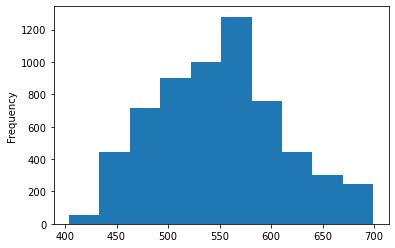

In [19]:
xy_train["BP"].plot(kind = "hist")

Boiling points are **approximately normally distributed**. No transformation necessary here.

#### Molecular weight

<AxesSubplot:ylabel='Frequency'>

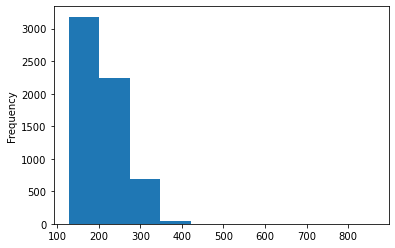

In [20]:
xy_train["molecular weight"].plot(kind = "hist")

In [21]:
xy_train["molecular weight"].describe()

count    6141.000000
mean      208.992212
std        48.129517
min       128.156501
25%       170.203451
50%       200.177630
75%       242.224580
max       860.478033
Name: molecular weight, dtype: float64

The molecular weight distribution is not normally distributed. Let's apply a log transformation:

In [22]:
from numpy import log10

<AxesSubplot:ylabel='Frequency'>

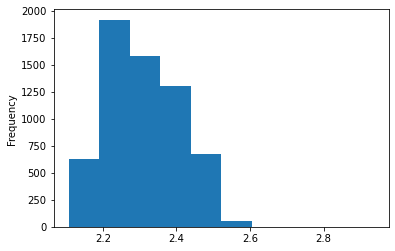

In [23]:
log10(xy_train["molecular weight"]).plot(kind = "hist")

In [24]:
log10(xy_train["molecular weight"]).describe()

count    6141.000000
mean        2.309206
std         0.096660
min         2.107741
25%         2.230968
50%         2.301416
75%         2.384218
max         2.934740
Name: molecular weight, dtype: float64

This distribution is still rather skewed, but **molecular weight will benefit from a logrithmic transformation**.

#### Hydrogen bond donors

<AxesSubplot:ylabel='Frequency'>

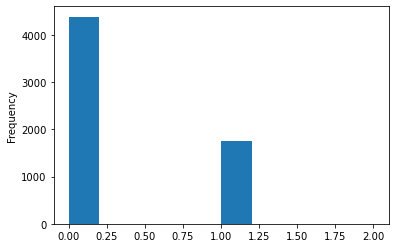

In [25]:
xy_train["H-Bond donors"].plot(kind = "hist")

In [26]:
xy_train["H-Bond donors"].describe()

count    6141.000000
mean        0.286924
std         0.454159
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         2.000000
Name: H-Bond donors, dtype: float64

**Oh no.** This data set contains virtually no molecules with more than one hydrogen bond donor. This is a problem that is best addressed by expanding the dataset to include, e.g., polyols, polyamines, etc.

#### Number of aromatic rings

<AxesSubplot:ylabel='Frequency'>

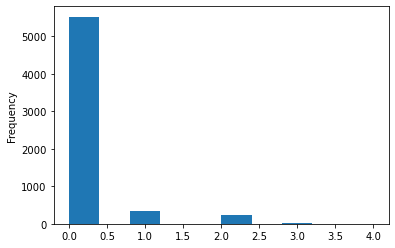

In [27]:
xy_train["rings, aromatic"].plot(kind = "hist")

This data doesn't nicely fit a particular distribution. Rather than trying to transform it, let's try upscaling the aromatics to create a new, augmented data set.

## Upsample the Aromatics data

As discussed above, there is an underwhelming amount of boiling point data for aromatic compounds. Let's upscale each class of aromatic compounds to be about 40% of the size of the non-aromatic class rather than <10 %.

In [28]:
from sklearn.utils import resample

In [29]:
aroms12 = resample(xy_train[(xy_train["rings, aromatic"] > 0) & (xy_train["rings, aromatic"] < 3)], n_samples = 2000, random_state = 7, replace = True)

In [30]:
aroms12.head()

,SMILES,BP,"rings, aromatic",H-Bond donors,molecular weight,branching fraction
1927,Cc1ccc2CCCCc2c1C,519.33,1,0,160.125201,0.000000
2056,Cc1ccc(cc1)c2ccc(C)cc2,568.20,2,0,182.109550,0.000000
5459,CCC(C)(C)c1ccc(N)cc1,526.18,1,1,163.136100,0.090909
5064,CCc1cccc(O)c1CC,509.80,1,1,150.104465,0.000000
5957,CCCCCCCCCCCCc1ccc2ccccc2c1,667.00,2,0,296.250401,0.000000


In [31]:
aroms12.shape

(2000, 6)

In [32]:
aroms3up = resample(xy_train[xy_train["rings, aromatic"] > 2], n_samples = 500, random_state = 7, replace = True)

In [33]:
aroms3up.head()

,SMILES,BP,"rings, aromatic",H-Bond donors,molecular weight,branching fraction
4978,[nH]1c2ccccc2c3ccccc13,628.20,3,1,167.073499,NaN
2001,Cc1cc(C)cc(c1)N(C2C3CC4CC(C3)CC2C4)[Mo](N(C5C6...,583.29,3,0,860.478033,0.222222
6071,Cc1cc2c(C)c3ccccc3c(C)c2cc1C,679.81,3,0,234.140851,0.000000
1948,Cc1ccc2cc3ccccc3cc2c1C,648.29,3,0,206.109550,0.000000
5627,CC(C)c1ccc2cc3c4ccccc4ccc3c5CCc1c25,506.15,4,0,296.156501,0.043478


Combine all the upsampled data, then save a new pair of training sets.

In [34]:
xy_train_upsampled = pd.concat([xy_train, aroms12, aroms3up])

In [35]:
xy_train_upsampled.head()

,SMILES,BP,"rings, aromatic",H-Bond donors,molecular weight,branching fraction
0,CCCCCCCCCC(C)CCCCCC=C,578.81,0,0,252.281701,0.055556
1,CCCC(C)c1ccccc1,473.15,1,0,148.125201,0.090909
2,CCc1cc(C)ccc1C,459.98,1,0,134.109550,0.000000
3,CCCCCCCCCCC(=O)CCCCCC,595.82,0,0,254.260966,0.000000
4,CCCCCCCCCC(C)OCC,511.26,0,0,200.214016,0.000000


In [37]:
xy_train_upsampled.shape

(8641, 6)

In [38]:
xy_train_upsampled["SMILES"].to_csv("data/x_train-CHNO_upsampled.csv", index = False)

In [39]:
xy_train_upsampled["BP"].to_csv("data/y_train-CHNO_upsampled.csv", index = False)